This notebook will outline some results of transformation kernels applied to DVS data in a SNN with LIF neurons. 

First lets import everything and set up some useful constants and functions and load the data once to save repetitive reads from disk. 

In [1]:
import numpy as np
from brian2 import *
%matplotlib inline

##   SOMEWHAT CONSTANTS
defaultclock.dt = 1*us
tau = 10*ms
eqs = '''
dv/dt = (I - v) / tau : 1 (unless refractory)  # Pick any model
I = 0: 1
'''


import struct
import os

V3 = "aedat3"
V2 = "aedat"  # current 32bit file format
V1 = "dat"  # old format

EVT_DVS = 0  # DVS event type
EVT_APS = 1  # APS event

RESX = 128
RESY = 128
RES = RESX * RESY
COLOURS = ['r', 'g', 'b', 'm', 'c', 'm', 'y', 'k']

##      Some helpful functions
flatIndex = lambda x, y : y*RESX + x
squareIndex = lambda i : (i % 128, int(i / 128))  # TODO there is probably some math todo for DAVIS 

## LOAD REAL DATA
file = 'M1a_expand.aedat'
#file = 'mipleft.aedat'
bytes2read = 30000



def loadaerdat(datafile='/tmp/aerout.dat', length=0, version=V2, debug=1, camera='DVS128'):
    """    
    load AER data file and parse these properties of AE events:
    - timestamps (in us), 
    - x,y-position [0..127]
    - polarity (0/1)

    @param datafile - path to the file to read
    @param length - how many bytes(B) should be read; default 0=whole file
    @param version - which file format version is used: "aedat" = v2, "dat" = v1 (old)
    @param debug - 0 = silent, 1 (default) = print summary, >=2 = print all debug
    @param camera='DVS128' or 'DAVIS240'
    @return (ts, xpos, ypos, pol) 4-tuple of lists containing data of all events;
    """
    # constants
    aeLen = 8  # 1 AE event takes 8 bytes
    readMode = '>II'  # struct.unpack(), 2x ulong, 4B+4B
    td = 0.000001  # timestep is 1us   
    if(camera == 'DVS128'):
        xmask = 0x00fe
        xshift = 1
        ymask = 0x7f00
        yshift = 8
        pmask = 0x1
        pshift = 0
    elif(camera == 'DAVIS240'):  # values take from scripts/matlab/getDVS*.m
        xmask = 0x003ff000
        xshift = 12
        ymask = 0x7fc00000
        yshift = 22
        pmask = 0x800
        pshift = 11
        eventtypeshift = 31
    else:
        raise ValueError("Unsupported camera: %s" % (camera))

    if (version == V1):
        print ("using the old .dat format")
        aeLen = 6
        readMode = '>HI'  # ushot, ulong = 2B+4B

    aerdatafh = open(datafile, 'rb')
    k = 0  # line number
    p = 0  # pointer, position on bytes
    statinfo = os.stat(datafile)
    if length == 0:
        length = statinfo.st_size    
    print ("file size", length)
    
    # header
    lt = aerdatafh.readline().decode('utf-8')
    while lt and lt[0] == "#":
        p += len(lt)
        k += 1
        lt = aerdatafh.readline().decode('utf-8') 
        if lt.startswith('#End of Preferences'):
            p += len(lt)   # TODO this is a bit lazy, rearrange logic
            k += 1
            break
        if debug >= 2:
            #print (str(lt))
            pass
        continue
    
    # variables to parse
    timestamps = []
    xaddr = []
    yaddr = []
    pol = []
    
    # read data-part of file
    aerdatafh.seek(p)
    s = aerdatafh.read(aeLen)
    p += aeLen
    length += p
    
    #print (xmask, xshift, ymask, yshift, pmask, pshift, aeLen,  p, length)    
    while p < length and p < statinfo.st_size:
        #print (xmask, xshift, ymask, yshift, pmask, pshift, aeLen,  p, length)
        #ii = int.from_bytes(s, byteorder='big')
        #print(str(bin(ii)), len(str(bin(ii))))
        print(type(s))
        addr, ts = struct.unpack(readMode, s)
        
        # parse event type
        if(camera == 'DAVIS240'):
            eventtype = (addr >> eventtypeshift)
        else:  # DVS128
            eventtype = EVT_DVS
        
        # parse event's data
        if(eventtype == EVT_DVS):  # this is a DVS event
            #print(str(bin(addr)), len(str(bin(addr))))
            x_addr = (addr & xmask) >> xshift
            y_addr = (addr & ymask) >> yshift
            a_pol = (addr & pmask) >> pshift


            if debug >= 3: 
                print("ts->", ts)  # ok
                print("x-> ", x_addr)
                print("y-> ", y_addr)
                print("pol->", a_pol)

            timestamps.append(ts)
            xaddr.append(x_addr)
            yaddr.append(y_addr)
            pol.append(a_pol)
            #poldf
        
        aerdatafh.seek(p)
        s = aerdatafh.read(aeLen)
        p += aeLen        

    if debug > 0:
        print(len(timestamps))
        try:
            print ("read %i (~ %.2fM) AE events, duration= %.2fs" % (len(timestamps), 
                                                                     len(timestamps) / float(10 ** 6), 
                                                                     (timestamps[-1] - timestamps[0]) * td))
            n = 5
            print ("showing first %i:" % (n))
            print ("timestamps: %s \nX-addr: %s\nY-addr: %s\npolarity: %s" % (timestamps[0:n], 
                                                                              xaddr[0:n], 
                                                                              yaddr[0:n], 
                                                                              pol[0:n]))
        except Exception as e:
            print(e)
            print ("failed to print statistics")

    return timestamps, xaddr, yaddr, pol


def rec_field(ofx, ofy, sizex, sizey, stim_res_x=RESX, stim_res_y=RESY):
    """ Given the offset in (x,y) and a size in x and y return a receptive field
        as a list of indices assuming camera stimulus if not specified for stim_res_*
        The offset plus corresponding size will not excede the retina
    """
    if ofx + sizex >= stim_res_x:
        sizex = stim_res_x - ofx
    if ofy + sizey >= stim_res_y:
        sizey = stim_res_y - ofy
    return [flatIndex(x, y) for x in range(ofx, sizex+ofx) for y in range(ofy, sizey+ofy)]

def dvs2group(xs, ys, ts):
    """ Given DVS data convert it to indices and timestamps that can be used by a Brian2 Spiking
        Neuron group. 
    """
    # TODO This means no 2 distinct neurons can fire at the same us.... Needs a fix
    real_indices = [flatIndex(*xy) for xy in zip(xs, ys)]
    real_times, uniq_idxs = np.unique(ts, return_index=True)
    real_indices = np.asarray(real_indices)[uniq_idxs]
    real_times = (real_times - real_times[0])*us
    return (real_indices, real_times)


# Finally load and process the data once
ts, xs, ys, ps = loadaerdat(datafile=file, length=bytes2read, version='aedat', debug=0, camera='DVS128')
real_indices, real_times = dvs2group(xs, ys, ts)

file size 30000
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class 'bytes'>
<class '

Okay lets define a SNN model

N 16


WARNING    /usr/local/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
 [py.warnings]
WARNING    /usr/local/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
 [py.warnings]


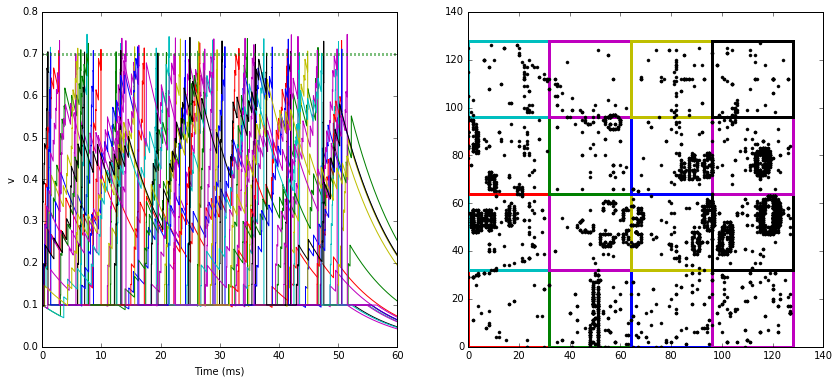

In [2]:
start_scope()

tau = 10*ms
eqs = '''
dv/dt = (I - v) / tau : 1 (unless refractory)  # Pick any model
I = 0: 1
'''

# TODO build receptive fields
field_size = 32    # Stick to powers of 2 larger than 16...
pixels_per_field = field_size * field_size


N = (RESX // field_size) * (RESY // field_size)
print("N " + str(N))

inp = SpikeGeneratorGroup(RES, real_indices, real_times)
G = NeuronGroup(N, eqs, threshold='v>0.7', reset='v=0.1', method='linear', refractory=5*ms)
S = Synapses(inp, G, 'w : 1', on_pre='v_post += w')

locs = [(x, y) for y in range(0, RESY, field_size) for x in range(0, RESX, field_size)]
rcsizes = [(field_size, field_size) for x in range(len(locs))]

# Set up fields for all neurons
for n in range(N):
    S.connect(i=np.array(rec_field(*(locs[n]), *(rcsizes[n]))), j=n)  

S.w = 0.05
G.v = 0.1

voltMon = StateMonitor(G, 'v', record=True)
spikesMon_opt = SpikeMonitor(G)




###############      RUN AND PLOT    ###############
run(60*ms)

figure(figsize=(14, 6))
subplot(121)
for n in range(N):
    plot(voltMon.t/ms, voltMon.v[n], '-'+COLOURS[n%len(COLOURS)], lw=1, label='N'+str(n))
    
axhline(0.7, ls=':', c='g', lw=3)  # Threshold line
xlabel('Time (ms)')
ylabel('v')
#legend(loc='best')

# Plot image and RC locations
ax = subplot(122)
plot(xs, ys, '.k')
for n in range(N):
    ax.add_patch(Rectangle(locs[n], *(rcsizes[n]), lw=3, color=COLOURS[n%len(COLOURS)], fill=False))



We now have a uniform grid of receptive fields non overlapping applied to the input data. Try changing the field size to see different results. Note when tried with a value of 4 the simulation ran out of memory (16 was successful). 

Now to insert transformation kernels, but first lets create a way to visualise the output of the network.

In [8]:
def vis_output(spikeMon, resx, resy):
    """ Given a spikeMonitor with variables t and i identifying neurons convert
        back to 2D coordinates and plot the response
    """
    times = spikeMon.t
    indexs_2dx = [i % resx for i in spikeMon.i]
    indexs_2dy = [int(i / resy) for i in spikeMon.i]
    
    heatmap, xedges, yedges = np.histogram2d(indexs_2dx, indexs_2dy, bins=resx)
    extent = [0,resx, 0,resy]#[xedges[0], xedges[-1], yedges[0], yedges[-1]]

    imshow(heatmap.T, extent=extent, origin='lower', interpolation='None')
    colorbar()

def vis_surface(surface, sizex=None, sizey=None):
    """ Given a surface draw it as a heatmap. If size not supplied, render in current
        shape, otherwise reshape to sizes given. Both arguements required or
        no reshaping will happen.
    """
    res = surface
    if sizex != None and sizey != None:
        res = np.zeros(shape=(sizey, sizex))
        for i in range(sizey):
            res[i, :] = surface[i*sizex : (i+1)*sizex]
            
    imshow(res, interpolation='None')
    colorbar()
    
def conv_layer(layer, layer_rc, kernel, kernel_rc, stride):
    """ Given a neuron layer and a surface (kernel of weights), create a set of synapses
        and a new layer that convolves that surface with the neuron layer with stride stride. 
        Returns tuple of (new_layer, new_synapses, locations)

        layer - a (NeuronGroup) group of neurons being input to new layer
        layer_rc - number of rows and colums of layer as tuple (row, col)
        kernel - 1D array of weights to be used as convolution kernel
        kernel_rc - rows and cols of kernel
        stride - stride between kernel convolutions
        locations - location of each receptive field
    """
    kr, kc = kernel_rc
    lr, lc = layer_rc
    
    r, c = (0, 0)
    locs = []  # Compute bottom left corner of each position for kernel
    while c + kc <= lc:    # TODO this can be faster if done analytically... 
        r = 0
        while r + kr <= lr:
            locs.append((r,c))
            r += stride
        c += stride
            
    print("Loc Num: ", len(locs))        
    ng = NeuronGroup(len(locs), eqs, threshold='v>0.7', reset='v=0.1', method='linear', refractory=5*ms)
    syns = Synapses(layer, ng, 'w : 1', on_pre='v_post += w')
    
    for n in range(len(locs)):
        arr = np.array(rec_field(*(locs[n]), kr, kc))
        syns.connect(i=arr, j=n)
        syns.w[:, n] = surface*0.05
    
    return (ng, syns, locs)    


Awesome now we have a layer feeding into the net, a sample kernel with unifrom coverage of the data and some spiking output response. 

N: 16, NX: 4, NY: 4


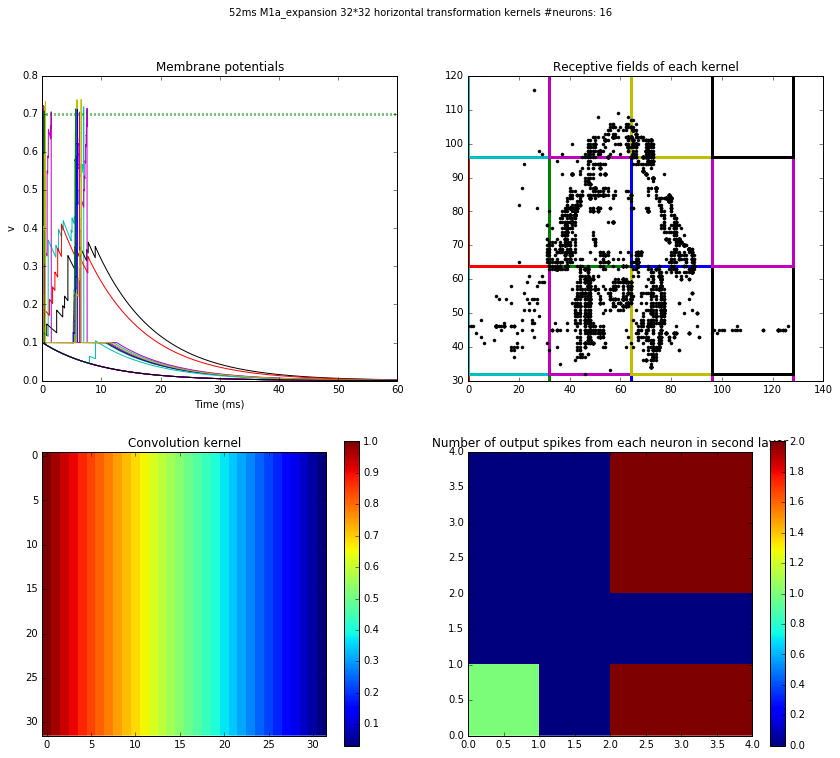

In [14]:
start_scope()

tau = 10*ms
eqs = '''
dv/dt = (I - v) / tau : 1 (unless refractory)  # Pick any model
I = 0: 1
'''

# build receptive fields
field_size = 32    # Stick to powers of 2 larger than 16...
field_sqrd = field_size * field_size

NX = RESX // field_size    # Number of needed neurons along x dimension 
NY = RESY // field_size    # Number needed in y dim
N = NX * NY                # Number total
print("N: {}, NX: {}, NY: {}".format(N, NX, NY))

inp = SpikeGeneratorGroup(RES, real_indices, real_times)
G = NeuronGroup(N, eqs, threshold='v>0.7', reset='v=0.1', method='linear', refractory=5*ms)
S = Synapses(inp, G, 'w : 1', on_pre='v_post += w')

locs = [(x, y) for y in range(0, RESY, field_size) for x in range(0, RESX, field_size)]
rcsizes = [(field_size, field_size) for x in range(len(locs))]

# Set up fields for all neurons
# ACTIVE LEFT
surface = np.array([(field_size - (i%field_size))/field_size for i in range(field_sqrd)])
# ACTIVE RIGHT
#surface = np.array([(i%field_size)/field_size for i in range(field_sqrd)])
for n in range(N):
    arr = np.array(rec_field(*(locs[n]), *(rcsizes[n])))
    S.connect(i=arr, j=n)  
    #horz = np.array([(i%field_size)/field_size for i in range(field_sqrd)])
    
    
    S.w[:, n] = surface*0.05

G.v = 0.1

voltMon = StateMonitor(G, 'v', record=True)
spikesMon_opt = SpikeMonitor(G)




###############      RUN AND PLOT    ###############
run(60*ms)

figure(figsize=(14, 12))
suptitle('52ms M1a_expansion 32*32 horizontal transformation kernels #neurons: ' + str(N))
subplot(221)
for n in range(N):
    plot(voltMon.t/ms, voltMon.v[n], '-'+COLOURS[n%len(COLOURS)], lw=1, label='N'+str(n))
    
axhline(0.7, ls=':', c='g', lw=3)  # Threshold line
xlabel('Time (ms)')
ylabel('v')
title('Membrane potentials')

#legend(loc='best')

# Plot image and RC locations
ax = subplot(222)
plot(xs, ys, '.k')
for n in range(N):
    ax.add_patch(Rectangle(locs[n], *(rcsizes[n]), lw=3, color=COLOURS[n%len(COLOURS)], fill=False))
title('Receptive fields of each kernel')

subplot(223)
vis_surface(surface, field_size, field_size)
title('Convolution kernel')

subplot(224)
title('Number of output spikes from each neuron in second layer')
vis_output(spikesMon_opt, NX, NY)



Now we have kernels working and can visualise output lets do a proper convolution

Loc Num:  49


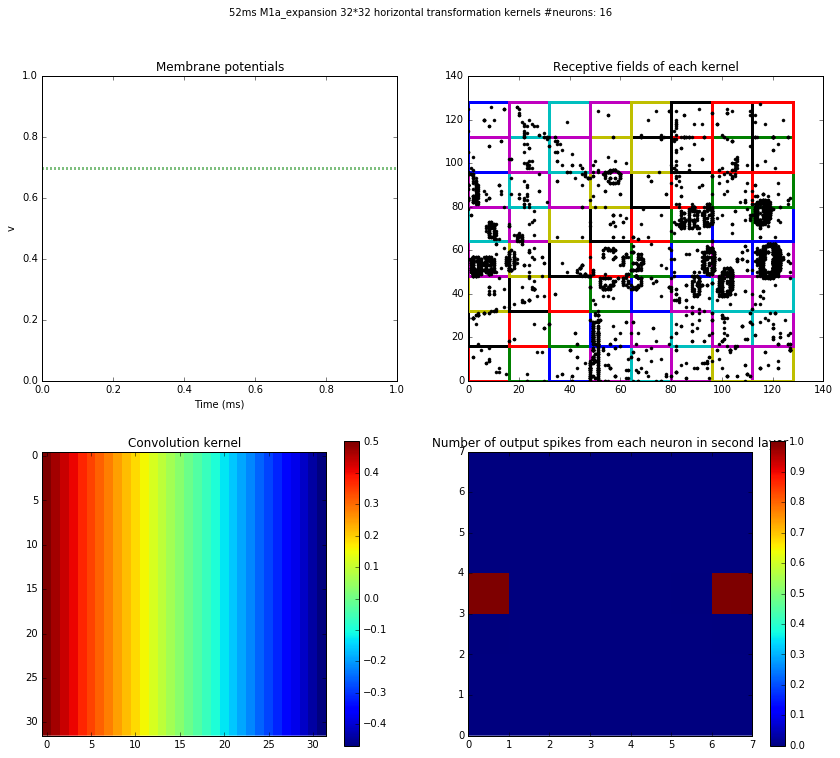

In [52]:
start_scope()

# build receptive fields
field_size = 32    # Stick to powers of 2 larger than 16...
stride = 16
field_sqrd = field_size * field_size

NX = RESX // field_size    # Number of needed neurons along x dimension 
NY = RESY // field_size    # Number needed in y dim
N = NX * NY                # Number total

inp = SpikeGeneratorGroup(RES, real_indices, real_times)
#G = NeuronGroup(N, eqs, threshold='v>0.7', reset='v=0.1', method='linear', refractory=5*ms)
#S = Synapses(inp, G, 'w : 1', on_pre='v_post += w')

surface = np.array([(field_size - (i%field_size))/field_size for i in range(field_sqrd)]) - 0.5
#surface = np.array([(i%field_size)/field_size for i in range(field_sqrd)])
G, S, locs = conv_layer(inp, (RESY, RESY), surface, (field_size, field_size), stride)
rcsizes = [(field_size, field_size) for i in range(len(locs))]


"""
locs = [(x, y) for y in range(0, RESY, field_size) for x in range(0, RESX, field_size)]
rcsizes = [(field_size, field_size) for x in range(len(locs))]

# Set up fields for all neurons
# ACTIVE LEFT
surface = np.array([(field_size - (i%field_size))/field_size for i in range(field_sqrd)])
# ACTIVE RIGHT
#surface = np.array([(i%field_size)/field_size for i in range(field_sqrd)])
for n in range(N):
    arr = np.array(rec_field(*(locs[n]), *(rcsizes[n])))
    S.connect(i=arr, j=n)  
    
    S.w[:, n] = surface*0.05
"""
G.v = 0.1

#voltMon = StateMonitor(G, 'v', record=True)
spikesMon_opt = SpikeMonitor(G)




###############      RUN AND PLOT    ###############
run(10*ms)

figure(figsize=(14, 12))
suptitle('52ms M1a_expansion 32*32 horizontal transformation kernels #neurons: ' + str(N))
subplot(221)
#for n in range(N):
#    plot(voltMon.t/ms, voltMon.v[n], '-'+COLOURS[n%len(COLOURS)], lw=1, label='N'+str(n))
#    
axhline(0.7, ls=':', c='g', lw=3)  # Threshold line
xlabel('Time (ms)')
ylabel('v')
title('Membrane potentials')

#legend(loc='best')



subplot(223)
vis_surface(surface, field_size, field_size)
title('Convolution kernel')

subplot(224)
title('Number of output spikes from each neuron in second layer')
vis_output(spikesMon_opt, np.sqrt(len(locs)), np.sqrt(len(locs)))

# Plot image and RC locations
ax = subplot(222)
plot(xs, ys, '.k')
for n in range(len(locs)):
    ax.add_patch(Rectangle(locs[n], *(rcsizes[n]), lw=3, color=COLOURS[n%len(COLOURS)], fill=False))
title('Receptive fields of each kernel')



WARNING    /usr/local/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:6: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
 [py.warnings]


[3, 3]


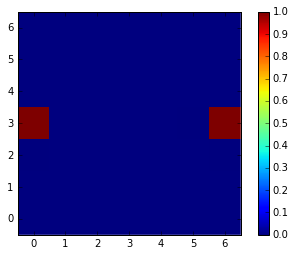

In [58]:
resx = np.sqrt(len(locs))
resy = resx

indexs_2dx = [int(i / resx) for i in spikesMon_opt.i]
indexs_2dy = [int(i % resy) for i in spikesMon_opt.i]
heat = np.zeros((resx, resy))
print(indexs_2dx)
for tup in zip(indexs_2dx, indexs_2dy):
    x, y = tup
    heat[x, y] += 1

imshow(heat, origin='lower', interpolation='None')
colorbar()

Above we can see how 32 by 32 receptive fields of a horizontal movement detector with stride of 8 can encode the activity of a scene. Further analysis will be needed to see how useful this is in its current state, it looks as if it is encoding the firing rate rather than extracting features. 

In [ ]:
rcsizes = [(field_size, field_size) for i in range(len(locs))]
figure(figsize=(14, 12))
suptitle('52ms M1a_expansion 32*32 horizontal transformation kernels #neurons: ' + str(len(locs)))
subplot(221)
for n in range(len(locs)):
    plot(voltMon.t/ms, voltMon.v[n], '-'+COLOURS[n%len(COLOURS)], lw=1, label='N'+str(n))
    
axhline(0.7, ls=':', c='g', lw=3)  # Threshold line
xlabel('Time (ms)')
ylabel('v')
title('Membrane potentials')

#legend(loc='best')

# Plot image and RC locations
ax = subplot(222)
plot(xs, ys, '.k')
for n in range(len(locs)):
    ax.add_patch(Rectangle(locs[n], *(rcsizes[n]), lw=3, color=COLOURS[n%len(COLOURS)], fill=False))
title('Receptive fields of each kernel')

subplot(223)
vis_surface(surface, field_size, field_size)
title('Convolution kernel')

subplot(224)
title('Number of output spikes from each neuron in second layer')
vis_output(spikesMon_opt, np.sqrt(len(locs)), np.sqrt(len(locs)))

In [1]:
print(len(locs))
print(np.sqrt(len(locs)))

NameError: name 'locs' is not defined

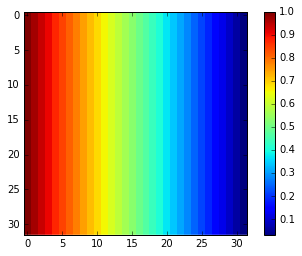

In [38]:
vis_surface(surface, field_size, field_size)

Now to be lazy, lets make this network a function which takes a surface to use so we can call it easily to create graphs.

In [ ]:
def make_network(surface, field_size=32, stride=8):
    start_scope()

    NX = RESX // field_size    # Number of needed neurons along x dimension 
    NY = RESY // field_size    # Number needed in y dim
    N = NX * NY                # Number total

    # build receptive fields
    #field_size = 8    # Stick to powers of 2 larger than 16...
    #stride = 8
    field_sqrd = field_size * field_size

    inp = SpikeGeneratorGroup(RES, real_indices, real_times)

    #surface = np.array([(field_size - (i%field_size))/field_size for i in range(field_sqrd)])
    #surface = np.array([(i%field_size)/field_size for i in range(field_sqrd)])
    G, S, locs = conv_layer(inp, (RESY, RESY), surface, (field_size, field_size), stride)
    rcsizes = [(field_size, field_size) for i in range(len(locs))]
    G.v = 0.1

    voltMon = StateMonitor(G, 'v', record=True)
    spikeMon_opt = SpikeMonitor(G)
    
    run(60*ms)
    
    return (voltMon, spikeMon_opt, locs, rcsizes)




def graph_network(voltMon, spikeMon_opt, locs, rcsizes, surface, save=False):
    figure(figsize=(14, 12))
    suptitle('52ms M1a_expansion {} #neurons: '.format(save) + str(len(locs)))
    subplot(221)
    for n in range(len(locs)):
        plot(voltMon.t/ms, voltMon.v[n], '-'+COLOURS[n%len(COLOURS)], lw=1, label='N'+str(n))

    axhline(0.7, ls=':', c='g', lw=3)  # Threshold line
    xlabel('Time (ms)')
    ylabel('v')
    title('Membrane potentials')

    #legend(loc='best')

    # Plot image and RC locations
    ax = subplot(222)
    plot(xs, ys, '.k')
    for n in range(len(locs)):
        ax.add_patch(Rectangle(locs[n], *(rcsizes[n]), lw=3, color=COLOURS[n%len(COLOURS)], fill=False))
    title('Receptive fields of each kernel')

    subplot(223)
    vis_surface(surface, field_size, field_size)
    title('Convolution kernel')

    subplot(224)
    title('Number of output spikes from each neuron in second layer')
    vis_output(spikeMon_opt, np.sqrt(len(locs)), np.sqrt(len(locs)))
    
    if save:
        savefig(save, bbox_inches='tight')
    
field_size=32
stride=16
dist = lambda p1, p2: np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)
for field_size in [32, 16]:
    
    field_sqrd = field_size * field_size
    surfs = []
    surf_names = 'CE'#'CELRDU'
    ##                              Add expansions
    mid = (field_size - 1) / 2 
    max_dist = dist((0,0), (mid, mid))
    surfs.append(np.array([ dist((i%field_size, i // field_size), 
                                 (mid, mid)) for i in range(field_sqrd)])/max_dist) 
    # Contraction
    surfs.append(1 - surfs[-1])                                                                   # Expansion
    ##                              Add horizontal and vertical
    #surfs.append(np.array([(i%field_size)/field_size for i in range(field_sqrd)]))                #left active
    #surfs.append(np.array([(field_size - (i%field_size))/field_size for i in range(field_sqrd)])) #right active
    #surfs.append(1 - surfs[-1])
    #surfs.append(np.array([(i//field_size)/field_size for i in range(field_sqrd)]))         #down active
    #surfs.append(np.array([1 - (i//field_size)/field_size for i in range(field_sqrd)]))       #up active
    #surfs.append(1 - surfs[-1])
    
    for stride in [16, 8]:
        for s_num in range(len(surfs)):
            surface = surfs[s_num]
            #print(surf.shape)
            name = '{}_{}field_{}stride.png'.format(surf_names[s_num], field_size, stride)
            voltMon, spikeMon_opt, locs, rcsizes = make_network(surface, field_size, stride)   # Make network
            graph_network(voltMon, spikeMon_opt, locs, rcsizes, surface, save=name)         # Graph network

Loc Num:  49
Loc Num:  49
Loc Num:  169


In [64]:
a = np.zeros((5,5))
a[3, 4] = 43
a[2, 4] = 13
print(np.unravel_index(find(a > 0), a.shape))
print(list(zip(np.unravel_index(find(a > 0), a.shape))))

(array([2, 3]), array([4, 4]))
[(array([2, 3]),), (array([4, 4]),)]


In [65]:
print(locs)

[(0, 0), (16, 0), (32, 0), (48, 0), (64, 0), (80, 0), (96, 0), (0, 16), (16, 16), (32, 16), (48, 16), (64, 16), (80, 16), (96, 16), (0, 32), (16, 32), (32, 32), (48, 32), (64, 32), (80, 32), (96, 32), (0, 48), (16, 48), (32, 48), (48, 48), (64, 48), (80, 48), (96, 48), (0, 64), (16, 64), (32, 64), (48, 64), (64, 64), (80, 64), (96, 64), (0, 80), (16, 80), (32, 80), (48, 80), (64, 80), (80, 80), (96, 80), (0, 96), (16, 96), (32, 96), (48, 96), (64, 96), (80, 96), (96, 96)]


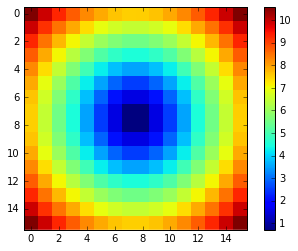

In [7]:
field_size = 16
field_sqrd = field_size**2
dist = lambda p1, p2: np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)
mid = (field_size - 1) / 2 
expansion = [ dist((i%field_size, i // field_size), (mid, mid)) for i in range(field_sqrd)]
vis_surface(expansion, field_size, field_size)

In [ ]:
###############               How to make a rotation kernel?
field_size = 16
field_sqrd = field_size**2
mid = (field_size - 1) / 2 
ang = lambda p1, p2: 
rot = [ ]
vis_surface(rot, field_size, field_size)